#### Notebook projet 6 parcours Datascientist Openclassrooms

# Classifiez automatiquement des biens de consommation

## Consignes
- mission: 
Pour ce projet il est demandé  de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

J'analyserai le jeu de données en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique m'aidera à convaincre le lead data scientist que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

On n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité !

## Import des librairies et réglage de Pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir

In [2]:
import missingno as msno
from sklearn import manifold, decomposition
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib.image import imread
import time, cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
 

In [3]:
import nltk
from string import punctuation
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import texthero as hero
from nltk import pos_tag, word_tokenize
from sklearn.decomposition import NMF

import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input


In [4]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import LatentDirichletAllocation

import re
import string

import spacy

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

## Déclaration des fonctions

In [5]:
# Fonction qui Tokenise et lemmatize les paragraphes

def lemma_filter_english_words(txtToLemmatize,
                               toSentence=True,
                               tagFilter=None):

    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag, word_tokenize
    sentenceToReturn = []
    wnl = WordNetLemmatizer()
    
    # Tokenize et tag each word of the sentence
    for word, tag in pos_tag(word_tokenize(txtToLemmatize)):
        # first letter in low case for the lemmatize fonction parameter
        wntag = tag[0].lower()
    
        if tagFilter:
            wntag = wntag if wntag in tagFilter else None
        else:
            wntag = wntag if wntag in ['r', 'n', 'v'] else None
            
        if wntag:
            lemma = wnl.lemmatize(word.lower(), wntag) 
        else:
            if tagFilter:
                continue
            else:
                lemma = word.lower()
                
        sentenceToReturn.append(lemma)
    
    if toSentence:
        return ' '.join(word for word in sentenceToReturn)
    else:
        return sentenceToReturn

In [6]:
def cat_levels(cat, lvl):
    cat = cat.split('["')[1].split('"]')[0]
    temp = cat.split(' >> ')
    if(len(temp)) < 3:
        temp = [temp[0], temp[1], 'None']
        if(len(temp))<2:
            temp = [temp[0], 'None', 'None']
    return temp[lvl]

def split_1(cat):
    return cat_levels(cat,0)
def split_2(cat):
    return cat_levels(cat,1)

In [7]:
def createKMeansLabelsFromTSNE(dictData, n_clusters=7):

    dictData['labels'] = pd.Series(KMeans(n_clusters=n_clusters)\
                                   .fit(dictData['tsne'])\
                                   .labels_,
                                   name='labels')
    return dictData

In [8]:
def reduction_Dimension_PCA_TSNE(dictData, col='histograms', pcaComponents=0.99):
        
    from scipy.sparse import issparse
    
    print(f'Treatment of the column {col}')
    print(f'Dimension of the original data set: {dictData[col].shape}')
    print('Start of PCA processing:')
    
    
    if pcaComponents <= 1:
        print(f'Variance preserved: {pcaComponents*100}%')
    else:
        print(f'Number of components conserved: {pcaComponents}')
        
    pca = PCA(n_components=pcaComponents)
    
    if issparse(dictData[col]):
        X_pca = pca.fit_transform(dictData[col].toarray())
    else:
        X_pca = pca.fit_transform(dictData[col])
    
    print(f'Data set size after PCA processing: {X_pca.shape}')
    print('End of PCA processing.')
    print(f'Start T-SNE processing:')
    
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X_pca)
    
    print(f'Size of the dataset after T-SNE processing: {X_tsne.shape}')
    print(f'End of T-SNE processing.')
    
    dictData['tsne'] = X_tsne
    
    return dictData

In [9]:
def showConfusionMatrix(dictData,
                        y_true='category',
                        y_pred='labels',
                        xlabel='Clusters',
                        ylabel='Product Categories'):
   
    # We guard against cases where y_true or y_pred are not numbers.
    le_true = LabelEncoder()
    le_pred = LabelEncoder()
    y_true= le_true.fit_transform(dictData[y_true])
    y_pred = le_pred.fit_transform(dictData[y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8,8))
    sns.heatmap(df_cm, annot=True, cmap="Blues",
                xticklabels=le_pred.classes_,
                yticklabels=le_true.classes_)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title('Confusion Matrix', fontsize=24)
    plt.show()

In [10]:
def displayTSNESortedByColor(dictData,hue='category',figsize=(12,7)):
    
    plt.figure(figsize=figsize)
    plt.title('Classification des produits suivant leur catégorie',
              fontsize=24)
    cmap = sns.color_palette("tab10",
                             n_colors=dictData[hue].nunique())
    sns.scatterplot(x=dictData['tsne'][:,0],
                    y=dictData['tsne'][:,1],
                    hue=dictData[hue],
                    palette=cmap)
    sns.color_palette("rocket_r",
                      as_cmap=True)
    plt.show()

In [11]:
def viewARIScore(dictData):
    print('ARI score between clustering according\nto categories and KMeans labels:',
          adjusted_rand_score(dictData['category'],
                              dictData['labels']))

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
def preProcessingImage(img, resize=False, gray=False, gaus=False, gausKernel=5, equ=False):

    if isinstance(img, str):
        # We consider that it is not an image but the path of the image
        img = cv2.imread(img, cv2.IMREAD_COLOR)
    
    resize = tuppleOfTwoInt(var=resize, varName='resize')
    if resize:
        img = cv2.resize(img, resize)
    if gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if gaus and tuppleOfTwoInt(var=gausKernel, varName='gausKernel'):
        gausKernel = tuppleOfTwoInt(var=gausKernel, varName='gausKernel')
        img = cv2.GaussianBlur(img, gausKernel, cv2.BORDER_DEFAULT)
    if equ:
        img = cv2.equalizeHist(img)
    
    return img

In [14]:
path = "C:/Users/Administrator/images"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [15]:
def createMatrixOfImages(dictData, size=224):

    listImages = []
    
    for img in dictData['path']:
        img = preProcessingImage(img, resize=size)
        img = preprocess_input(img)
        listImages.append(img)
    print(f'Dimensions of the image matrix: {np.array(listImages).shape}')
    dictData['arrayImg'] = np.array(listImages)
    return dictData

In [16]:
def tuppleOfTwoInt(var=False, varName=''):

    if varName:
        varName = str.strip(varName)+' '
    if isinstance(var, bool):
        if var:
            print(f'TuppleOfTwoInt : The format of the {varName}argument is incorrect')
        return False
    elif isinstance(var, int):
        return (var,var)    
    elif isinstance(var, tuple):
        if contains_only_integers(var):
            if len(var) == 2:
                return var    
    print(f'TuppleOfTwoInt : The format of the {varName}argument is incorrect')
    return False

In [17]:
def pca_function(to_fit):
    pca = PCA(n_components=1000, 
              random_state=12,
             ).fit(to_fit)
    x = pca.transform(to_fit)
    print(x.shape, end='\n\n')
    return pca, x

def pca_graph(pca):
    cum_var = pca.explained_variance_ratio_*100 #percentage
    plt.figure(figsize=(12,5))
    plt.plot(np.arange(len(cum_var))+1, np.cumsum(cum_var))
    plt.title('Somme cumulée de variance des composantes du PCA : 99%')
    plt.xlabel('Nombre de composantes du PCA')
    plt.ylabel('Variance cumulée (%)')
    plt.axhline(99, lw=1, c='blue')
    plt.text(1, 99, '99%', c='blue')
    plt.show()

In [18]:
def combineTwoMatricesInOne(dictData,
                            finalKey='vectors',
                            key1='tfidf',
                            key2='histograms'):
    vectors = []
    
    print('Dimensions of two matrices:')
    print(f'   Matrix n°1 -- Name: {key1} -- Shape: {dictData[key1].shape}')
    print(f'   Matrix n°2 -- Name: {key2} -- Shape: {dictData[key2].shape}')
    
    for idx,vect in enumerate(dictData[key1]):
        vectors.append(np.concatenate((vect.toarray()[0],
                                       dictData[key2][idx])))
    dictData[finalKey] = np.array(vectors)
    print(f'Final matrix -- Name: {finalKey} -- Shape: {dictData[finalKey].shape}')
    return dictData

## Import des données

In [19]:
path = "C:/Users/Administrator/images"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [20]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [21]:
data.head(3).T

,0,1,2
uniq_id,55b85ea15a1536d46b7190ad6fff8ce7,7b72c92c2f6c40268628ec5f14c6d590,64d5d4a258243731dc7bbb1eef49ad74
crawl_timestamp,2016-04-30 03:22:56 +0000,2016-04-30 03:22:56 +0000,2016-04-30 03:22:56 +0000
product_url,http://www.flipkart.com/elegance-polyester-mul...,http://www.flipkart.com/sathiyas-cotton-bath-t...,http://www.flipkart.com/eurospa-cotton-terry-f...
product_name,Elegance Polyester Multicolor Abstract Eyelet ...,Sathiyas Cotton Bath Towel,Eurospa Cotton Terry Face Towel Set
product_category_tree,"[""Home Furnishing >> Curtains & Accessories >>...","[""Baby Care >> Baby Bath & Skin >> Baby Bath T...","[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
pid,CRNEG7BKMFFYHQ8Z,BTWEGFZHGBXPHZUH,BTWEG6SHXTDB2A2Y
retail_price,1899.0,600.0,NaN
discounted_price,899.0,449.0,NaN
image,55b85ea15a1536d46b7190ad6fff8ce7.jpg,7b72c92c2f6c40268628ec5f14c6d590.jpg,64d5d4a258243731dc7bbb1eef49ad74.jpg
is_FK_Advantage_product,False,False,False


## Analyse des données

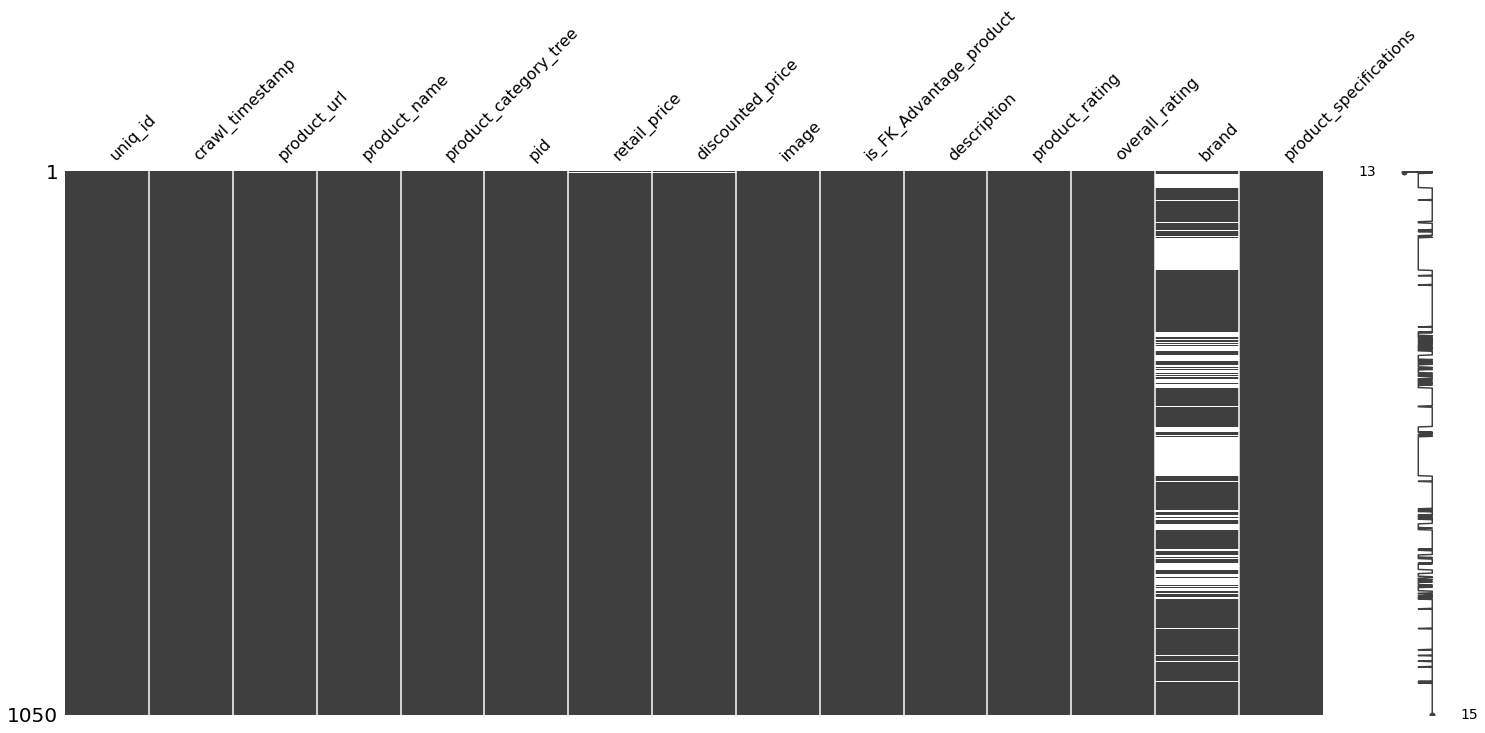

In [22]:
import missingno as msno
msno.matrix(data);

In [23]:
# Cardinalité de data
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [24]:
data2 = data.copy()[['product_name','product_category_tree','description', 'image']]
data2.head()

,product_name,product_category_tree,description,image
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg


## Classification des produits grâce à leurs données textuelles descriptives
Dans cette partie nous allons **classer** et **regrouper** nos produits en autant de groupes qu'il existe de catégories. <br />
Nous réaliserons cela à travers notre **moteur de classification** à partir des textes qui servent à les décrire.

la feature qui permet de décrire un produit :
 - La description de l'objet: "**description**"

In [25]:
#Les colonnes product_category_tree ont différents niveaux de catégories tabulés par >>.

data2['category'] = data2['product_category_tree'].apply(split_1)
data2['category_2'] = data2['product_category_tree'].apply(split_2)

In [26]:
data2.sample(3)

,product_name,product_category_tree,description,image,category,category_2
687,Jovees Anjeer & Carrot Sunblock (Pack of 2) - ...,"[""Beauty and Personal Care >> Body and Skin Ca...",Flipkart.com: Buy Jovees Anjeer & Carrot Sunbl...,d61b368146f83075937e144dab93c6a1.jpg,Beauty and Personal Care,Body and Skin Care
528,Sonata 8944SL03 Analog Watch - For Women,"[""Watches >> Wrist Watches >> Sonata Wrist Wat...",Sonata 8944SL03 Analog Watch - For Women - Bu...,4a4ccd1ac291cfc8b3894e691a1c0f7a.jpg,Watches,Wrist Watches
913,Like Analog Purple Clock,"[""Watches >> Clocks >> Table Clocks >> Like Ta...",Specifications of Like Analog Purple Clock Fun...,89b95537d8697203ab278237289a52a8.jpg,Watches,Clocks


In [27]:
data2.groupby('category').count()['product_name'].sort_values(ascending=False)

category
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: product_name, dtype: int64

In [29]:
data2.groupby('category_2').count()['product_name'].sort_values(ascending=False)

category_2
Wrist Watches                149
Laptop Accessories            87
Infant Wear                   84
Coffee Mugs                   74
Showpieces                    71
                            ... 
Dinnerware & Crockery          1
Men's Grooming                 1
Beauty Accessories             1
Kripa's Home Furnishing        1
Consumables & Disposables      1
Name: product_name, Length: 62, dtype: int64

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


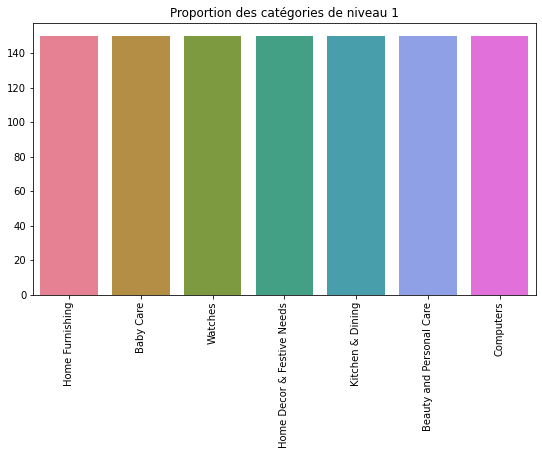

In [30]:
fig = plt.figure(1, figsize=(9, 5))
cat_level2 = data2['category'].value_counts()
plt.title('Proportion des catégories de niveau 1')
sns.barplot(cat_level2.index, cat_level2.values)
plt.xticks(rotation=90)
plt.show()

C:\Users\Administrator\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


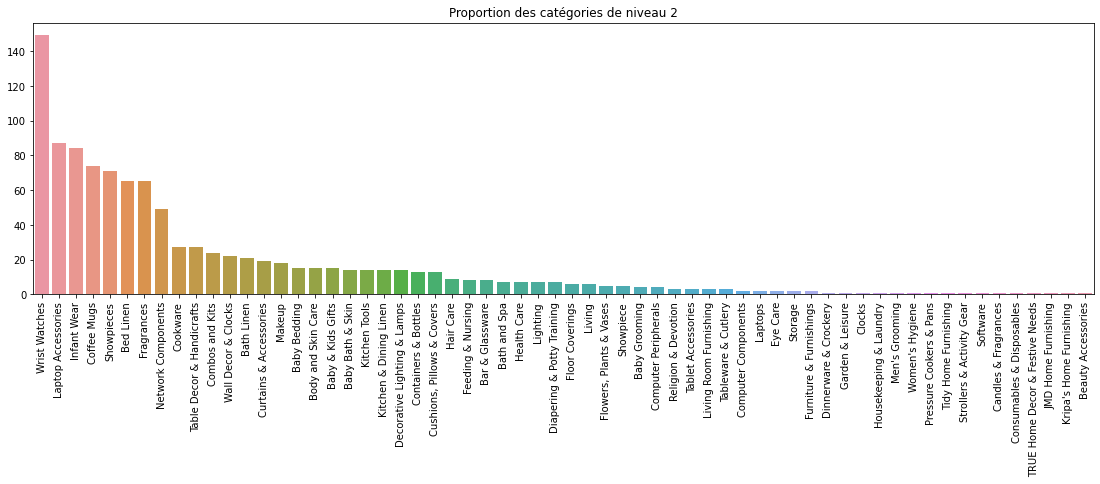

In [31]:
fig = plt.figure(1, figsize=(19, 5))
cat_level2 = data2['category_2'].value_counts()
plt.title('Proportion des catégories de niveau 2')
sns.barplot(cat_level2.index, cat_level2.values)
plt.xticks(rotation=90)
plt.show()

#### Pour l'exercice nous n'allons conserver que le premier niveau de catégories de chaque produit.

In [32]:
data2.drop('category_2',
        axis=1,
        inplace=True)

In [33]:
data2.drop('product_category_tree',
        axis=1,
        inplace=True)

In [34]:
data2.head(3)

,product_name,description,image,category
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care


In [35]:
# Je crée 2 colonnes contenant le nombre de mots dans les features: "product_name"et "description"
data2['count_product_name'] = data2['product_name']\
                            .apply(lambda row: row.count(' ') + 1)
data2['count_description'] = data2['description']\
                            .apply(lambda row: row.count(' ') + 1)


In [36]:
cat = data2.groupby('category').mean()[['count_description',
                                     'count_product_name']]

In [37]:
data2.head(3)

,product_name,description,image,category,count_product_name,count_description
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,7,230
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,4,74
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,6,215


In [38]:
cat

,count_description,count_product_name
category,,
Baby Care,80.146667,6.420000
Beauty and Personal Care,60.513333,7.953333
Computers,89.806667,7.846667
Home Decor & Festive Needs,99.026667,9.660000
Home Furnishing,65.113333,6.173333
Kitchen & Dining,112.880000,6.346667
Watches,54.766667,8.920000


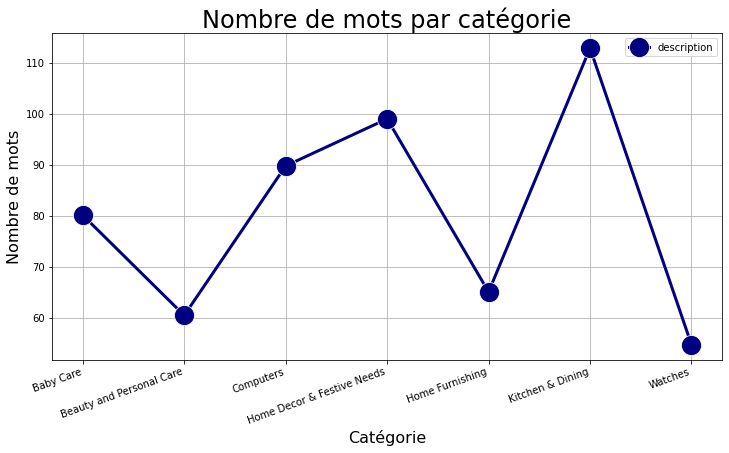

In [40]:
plt.figure(figsize=(12,6))
sns.lineplot(x=cat.index,
             y=cat['count_description'],
             linewidth=3,
             marker='o',
             markersize=20,
             label='description',
             color='navy')


plt.legend()
plt.xlabel('Catégorie',fontsize=16)
plt.xticks(rotation=20,ha='right')
plt.ylabel('Nombre de mots',fontsize=16)
plt.title('Nombre de mots par catégorie', fontsize=24)
plt.grid()
plt.show()

- Le nombre de mots utilisés en moyenne pour décrire un produit est inégalement réparti entre les catégories, pouvant aller pratiquement du simple au double.


# Préparation des données Textuelles

In [351]:
#Visualiser le maximum possible d'information
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-351-0c6fc7a42ec0>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [41]:
data2[['description']].sample(3)

,description
719,Flipkart.com is offering Pompom Sweethearts Ve...
1041,Buy Wallmantra Extra Large Vinyl Stickers Stic...
34,Key Features of House This Queen Cotton Duvet ...


### Nettoyage du text

##### Les champs de texte sont nettoyés (retirer la ponctuation, les mots de liaison, mettre tout en minuscule)

In [42]:
#Avant Traitement :
print(f'Nombre de mots avant traitement : {data2.description[7].count(" ") + 1}\n')
print(data2.description[7])

Nombre de mots avant traitement : 154

T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys
                         Price: Rs. 399
				
			Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.
Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.


Cette étape est très importante pour l'optimisation de notre moteur de classification.

Nous allons nettoyer et normaliser nos descriptions en effectuant un ensemble d'opérations détaillées ci-dessous.

Pour cette étape, j'utilise la bilibliothèque **texthero**.

**Utilisation de text hero**:

<u>La méthode clean effectue le traitement suivant</u> :
1. texthero.preprocessing.**fillna()**
2. texthero.preprocessing.**lowercase()**: Passe la chaîne de caractère en minuscule: Remplace tous les digits par un seul espace
4. texthero.preprocessing.**remove_punctuation()**: Remplace tous les signes de ponctuation par un seul espace
5. texthero.preprocessing.**remove_diacritics()**: Supprime tous les diacritiques et les accents
6. texthero.preprocessing.**remove_stopwords()**: Supprime les stopwords issues d'une liste de 179 stopwords de la bibliothèque NLTK.
7. texthero.preprocessing.**remove_whitespace()**: Supprime les espaces inutiles en début et en fin de chaîne, les sauts de ligne, les tabulations et toute forme d'espace

In [43]:
data2['desc_clean'] = data2['description'].pipe(hero.clean)

In [44]:
#Apres Normalisation :
print(f'Nombre de mots après normalisation : {data2.desc_clean[7].count(" ") + 1}\n')
print(data2.desc_clean[7])

Nombre de mots après normalisation : 74

star uft tsw bk br analog watch boys price rs whether way work travelling abroad family lifestyle accessories like watches wallets belts help add touch sophistication class otherwise mundane regular daily wear comes suave leather belts intricately designed finished timepieces separate rest whether way work travelling abroad family lifestyle accessories like watches wallets belts help add touch sophistication class otherwise mundane regular daily wear comes suave leather belts intricately designed finished timepieces separate rest


### Tokenisation du texte

In [45]:
phrase = word_tokenize(data2.loc[7,"desc_clean"])
print(f' Texte apres Tokenisation :\n')
print(phrase, end='\n\n')

 Texte apres Tokenisation :

['star', 'uft', 'tsw', 'bk', 'br', 'analog', 'watch', 'boys', 'price', 'rs', 'whether', 'way', 'work', 'travelling', 'abroad', 'family', 'lifestyle', 'accessories', 'like', 'watches', 'wallets', 'belts', 'help', 'add', 'touch', 'sophistication', 'class', 'otherwise', 'mundane', 'regular', 'daily', 'wear', 'comes', 'suave', 'leather', 'belts', 'intricately', 'designed', 'finished', 'timepieces', 'separate', 'rest', 'whether', 'way', 'work', 'travelling', 'abroad', 'family', 'lifestyle', 'accessories', 'like', 'watches', 'wallets', 'belts', 'help', 'add', 'touch', 'sophistication', 'class', 'otherwise', 'mundane', 'regular', 'daily', 'wear', 'comes', 'suave', 'leather', 'belts', 'intricately', 'designed', 'finished', 'timepieces', 'separate', 'rest']



### Lemmatisation du texte

Le processus de « lemmatisation » consiste à représenter les mots (ou « lemmes ») sous leur forme canonique.
Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier.
L'idée étant encore une fois de ne conserver que le sens des mots utilisés dans le corpus.

In [46]:
data2['desc_lemma'] = \
    data2['desc_clean']\
        .apply(lambda row: \
               lemma_filter_english_words(row,
                                          tagFilter=['n',
                                                     'v']))

In [47]:
#Après lemmatisation :
print(f'Nombre de mots après lemmatisation : {data2.loc[7,"desc_lemma"].count(" ") + 1}\n')
data2.loc[7,'desc_lemma']

Nombre de mots après lemmatisation : 51



'star tsw bk br analog watch boys price r way work travel family accessory watch wallet belt help add sophistication class wear come suave leather belt design finish timepiece rest way work travel family accessory watch wallet belt help add sophistication class wear come suave leather belt design finish timepiece rest'

In [48]:
data2['desc_token'] = (data2['desc_lemma']).apply(lambda x:word_tokenize(x))

In [49]:
data2.head(1)

,product_name,description,image,category,count_product_name,count_description,desc_clean,desc_lemma,desc_token
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,7,230,key features elegance polyester multicolor abs...,feature elegance polyester multicolor eyelet d...,"[feature, elegance, polyester, multicolor, eye..."


### Bagof words

Bag-of-words :
La méthode BOW consiste à créer un dataframe avec des colonnes pour chaque mot différent présent dans le corpus (l'ensemble des descriptions dans la colonne description) et d'indiquer le nombre de fois qu'il apparait dans chaque description de chaque article. Donc, nous créons un histogramme de l'apparition des mots dans l'ensemble des descriptions.

In [50]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [51]:
stopW_nltk = set(nltk.corpus.stopwords.words('english'))
stopW_punct = set(punctuation)
stopW_list = set.union(stopW_nltk, stopW_punct)

In [52]:
bow_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                                 encoding='utf-8',
                                 strip_accents='unicode', 
                                 stop_words=stopW_list,
                                 lowercase=True,
                                 analyzer='word',
                                 min_df=5,
                                )

bow_ft = bow_vectorizer.fit_transform(data2['desc_token'].astype('U'))
bow_df = pd.DataFrame(bow_ft.toarray(),columns=bow_vectorizer.get_feature_names())
print(bow_df.shape)
bow_df.head(5)

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(1050, 683)


,'abstract,'ac,'accessory,'adapter,'add,'addition,'age,'air,'akup,'alarm,...,'yes,b,e,g,h,l,r,v,w,x
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


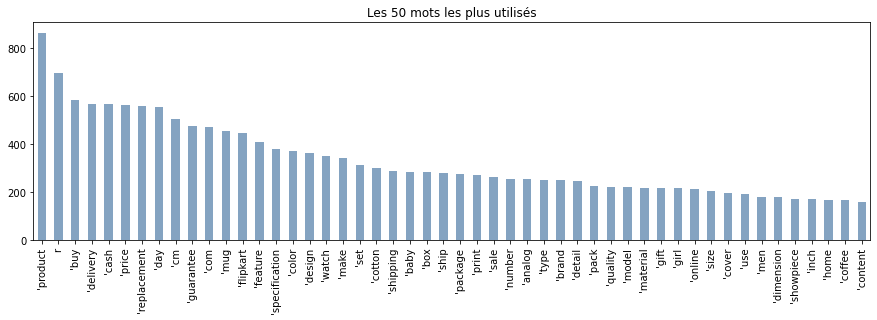

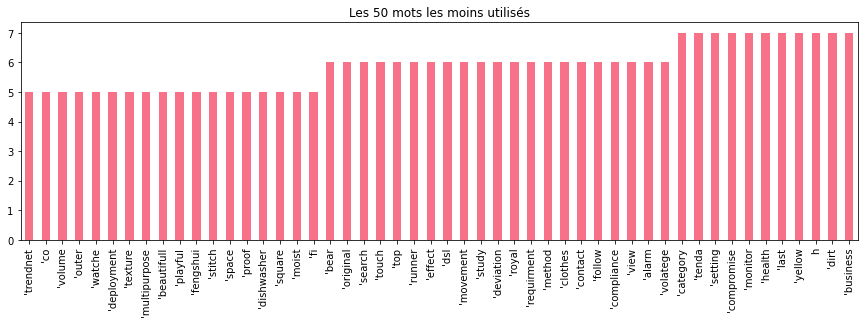

In [53]:
plt.title('Les 50 mots les plus utilisés')
bow_df.sum(axis=0).sort_values(ascending=False)[:50].plot.bar(figsize=(15,4),color=(0.2, 0.4, 0.6, 0.6))
plt.show()

plt.title('Les 50 mots les moins utilisés')
bow_df.sum(axis=0).sort_values(ascending=True)[:50].plot.bar(figsize=(15,4))
plt.show()

### TF-IDF "Term-Frequency - Inverse Document Frequency"

Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus.

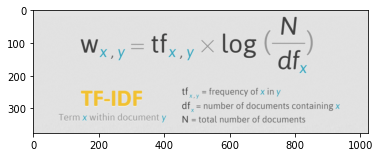

In [54]:
import matplotlib.image as img
import matplotlib.pyplot as plt
image3 = img.imread('https://www.seoquantum.com/sites/default/files/tf-idf-2-1-1024x375.png')
plt.imshow(image3)

In [55]:
dictTxt = {}

In [56]:
dictTxt['category'] = data2.category

In [57]:
#Création de la matrice tf-idf :
from sklearn.feature_extraction.text import TfidfVectorizer
dictTxt['tfidf'] = TfidfVectorizer()\
                     .fit_transform(data2['desc_lemma'])

In [58]:
dictTxt['tfidf']

<1050x3508 sparse matrix of type '<class 'numpy.float64'>'
	with 25223 stored elements in Compressed Sparse Row format>

### Réduction de dimension PCA / T-SNE

Afin nous permettre de visualiser graphiquement les regroupements de nos produits en fonction de leur description mais également d'améliorer les performances de notre moteur de classification, nous allons appliquer une réduction de dimension à notre matrice **tf-idf**.

L'objectif ici est de ramener nos vecteurs en **2 dimensions**.

Nous allons utiliser pour cela l'algorithme **T-SNE**.

Cependant le charge peut-être très lourde en termps de calcul.<br />
Pour éviter cette problématique,nous allons appliquer une première réduction de dimension en appliquant une Analyse en Composante Principale.<br />
Nous ferons le choix de conserver **99% de la variance** afin de ne pas sacrifier la qualité de nos données tout en réduisant drastiquement le temps necessaire à l'application de **T-SNE** pour la réduction en 2 dimensions de nos vecteurs TF-IDF.

(1050, 1000)



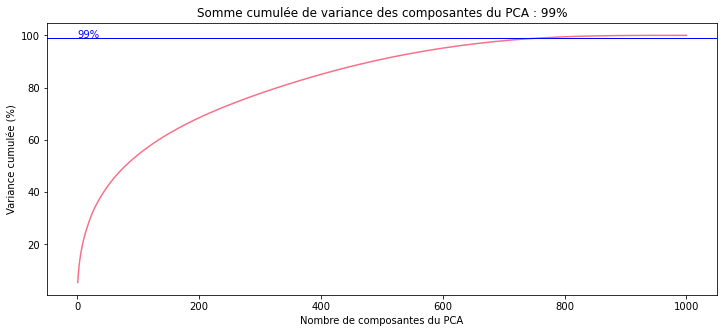

In [59]:
pca, x = pca_function(dictTxt['tfidf'].toarray())
pca_graph(pca)

In [65]:
dictTxt = reduction_Dimension_PCA_TSNE(dictTxt, col='tfidf')

Treatment of the column tfidf
Dimension of the original data set: (1050, 3508)
Start of PCA processing:
Variance preserved: 99.0%
Data set size after PCA processing: (1050, 761)
End of PCA processing.
Start T-SNE processing:
Size of the dataset after T-SNE processing: (1050, 2)
End of T-SNE processing.


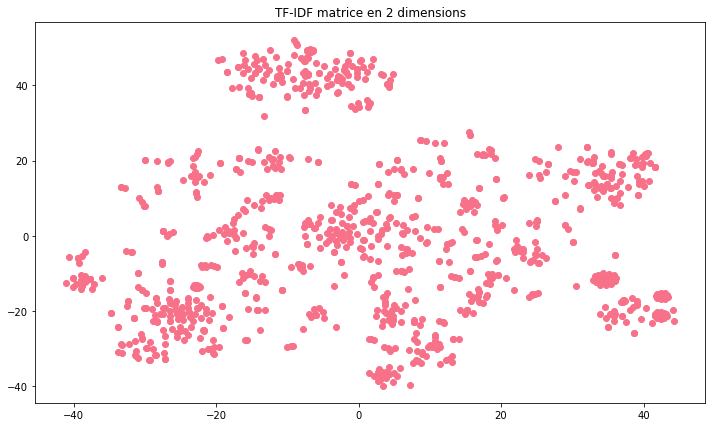

In [66]:
#Nous pouvons afficher notre matrice TF-IDF maintenant réduite en 2 dimensions où chaque point représente un produit :
plt.figure(figsize=(12,7))
plt.scatter(dictTxt['tsne'][:,0], dictTxt['tsne'][:,1])
plt.title('TF-IDF matrice en 2 dimensions')
plt.show()

In [67]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Displays a scatterplot of a 2-dimensional matrix contained in the key "tsne" of the dictionary communicated as argument.
The idea is to display the result of a T-SNE dimension reduction in 2 dimensions.
The color of the points is a function of the argument <hue> communicated in argument and refers to a key of the dictionary.
   

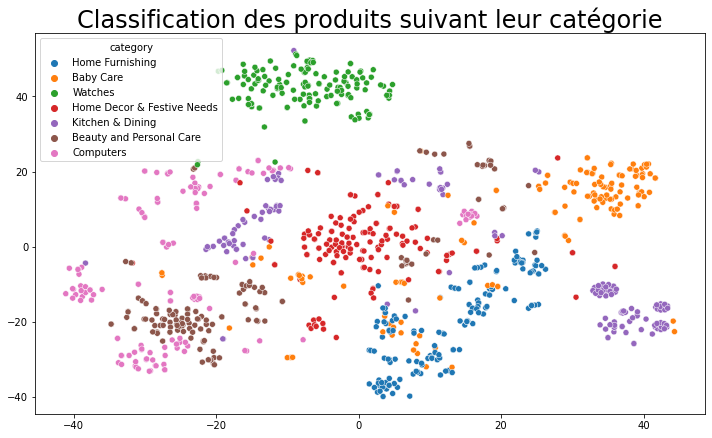

In [68]:
# Affichage de la classification des descriptions selon leurs catégories
displayTSNESortedByColor(dictTxt,hue='category')

Certaines catégories semblent très bien regroupées comme "**Watches**" .<br />
D'autres sont plus diffuses comme "**computers**".

On peut émettre l'hypothèse que les groupes <correctement taggés ont un vocubulaire très spécifique alors que les autres ont un vocubulaire plus général susceptible d'être présent dans plusieurs catégories.

### K-Means sur matrice T-SNE

L'idée à présent et de faire comme si nous ne connaissions pas la réelle catégorie des produits.

A partir de la matrice **T-SNE**, nous allons regrouper, via l'algorithme **K-Means** les points selon **7 clusters**.<br />
Chaque cluster représente l'une des 7 catégories.

In [69]:
dictTxt = createKMeansLabelsFromTSNE(dictTxt)

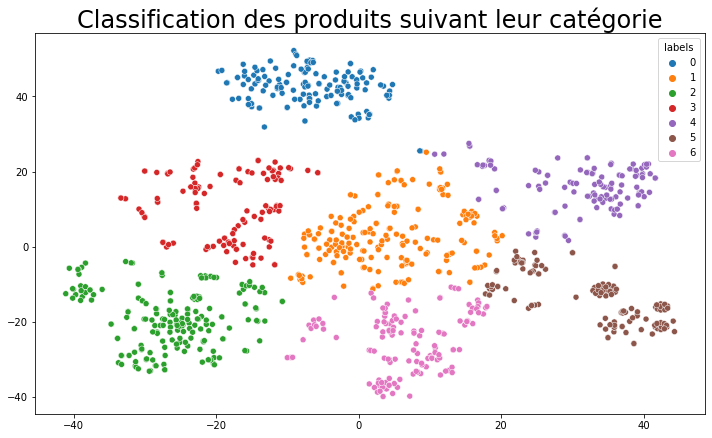

In [70]:
# Affichage de la classification des descriptions selon leurs clusters  K-Means
displayTSNESortedByColor(dictTxt,hue='labels')

In [74]:
def showConfusionMatrix2(dictData,
                        y_true='category',
                        y_pred='labels',
                        xlabel='Clusters',
                        ylabel='Product Categories'):

    # We guard against cases where y_true or y_pred are not numbers.
    le_true = LabelEncoder()
    le_pred = LabelEncoder()
    y_true= le_true.fit_transform(dictData[y_true])
    y_pred = le_pred.fit_transform(dictData[y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8,8))
    sns.heatmap(cm,cmap="Blues",
                fmt="d",
                annot=True,
                linewidths=.5,
                xticklabels=le_pred.classes_,
                yticklabels=le_true.classes_)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title('Confusion Matrix', fontsize=24)
    plt.show()

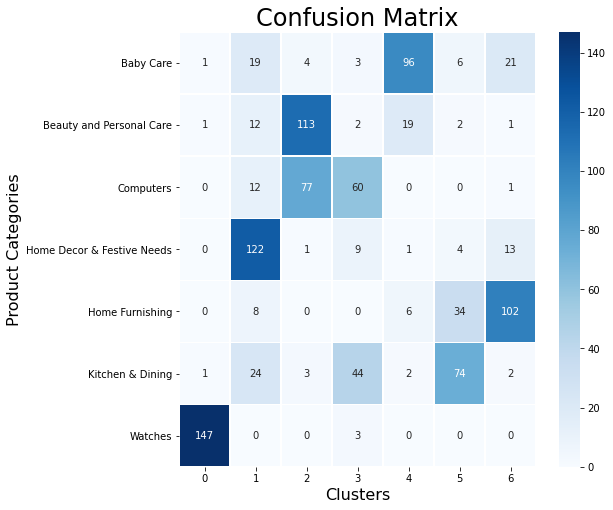

In [76]:
#Utilisons la matrice de confusion pour visualiser les erreurs de classement.
showConfusionMatrix2(dictTxt)

Les catégories ont la majorité de leurs produits qui sont correctements classés.<br />
Les clusters peuvent être attribués à leur catégorie respective en identifiant, pour chaque catégorie, le cluster qui la représente le plus.<br />
La catégorie "**Home furnishing**" est la catégorie la plus difficile à classer. Presque la moitié des produits est attribuée à tort à la catégorie "**Baby care**."

#### Calcul du Score ARI

Pour mesurer l'erreur de notre moteur de classification, nous allons utiliser la métrique **ARI** via la fonction **adjusted_rand_score** de sklearn.

L'**adjusted_rand_score** calcule une mesure de similarité entre deux groupements en considérant toutes les paires d'échantillons et en comptant les paires qui sont assignées dans le même groupement ou dans des groupements différents dans les groupements prédits et réels.

*Le score ARI va de 0 pour un étiquetage aléatoire à 1 pour un étiquetage parfait*.

In [293]:
viewARIScore(dictTxt)

ARI score between clustering according
to categories and KMeans labels: 0.4540498216236013


In [312]:
# !pip install pyldavis

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a7e0be709978baf814b77b528d67ee30ec4308b6451f66e12681b5832baced82
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\90\61\ec\9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=bd7a9091bacc73e1834cb50e8d8a0d07d3dddd7fabcbc469a41ca1c8add17e34
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc

# LDA  "Latent Dirichlet Allocation"


L’allocation de Dirichlet latente (de l'anglais Latent Dirichlet Allocation) ou LDA est un modèle génératif probabiliste permettant d'expliquer des ensembles d'observations, par le moyen de groupes non observés, eux-mêmes définis par des similarités de données.

Par exemple, si les observations (β) sont les mots collectés dans un ensemble de documents textuels (M), le modèle LDA suppose que chaque document (M) est un mélange (θ) d'un petit nombre de sujets ou thèmes (α topics), et que la génération de chaque occurrence d'un mot (w) est attribuable (probabilité) à l'un des thèmes (t) du document

In [77]:
dictionary = corpora.Dictionary(data2['desc_token'])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in data2['desc_token']]

In [78]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=12,
                chunksize=1000, passes=50,iterations=100)

In [79]:
lda_model.print_topics()

[(0,
  '0.090*"skin" + 0.057*"shape" + 0.054*"print" + 0.043*"pad" + 0.042*"mouse" + 0.034*"set" + 0.034*"warranty" + 0.033*"inch" + 0.032*"combo" + 0.024*"multicolor"'),
 (1,
  '0.080*"sticker" + 0.058*"wall" + 0.029*"vinyl" + 0.020*"use" + 0.017*"home" + 0.017*"size" + 0.016*"quality" + 0.016*"surface" + 0.013*"e" + 0.013*"piece"'),
 (2,
  '0.042*"cm" + 0.037*"model" + 0.036*"design" + 0.036*"polyester" + 0.032*"comfort" + 0.030*"eyelet" + 0.030*"aroma" + 0.024*"height" + 0.024*"box" + 0.023*"specification"'),
 (3,
  '0.055*"product" + 0.038*"buy" + 0.038*"delivery" + 0.037*"cash" + 0.036*"day" + 0.035*"replacement" + 0.033*"guarantee" + 0.026*"r" + 0.024*"com" + 0.024*"price"'),
 (4,
  '0.041*"watch" + 0.029*"analog" + 0.020*"men" + 0.019*"r" + 0.018*"woman" + 0.017*"pot" + 0.016*"discount" + 0.015*"price" + 0.014*"brow" + 0.013*"set"'),
 (5,
  '0.031*"apply" + 0.022*"lock" + 0.022*"sing" + 0.020*"hair" + 0.019*"use" + 0.018*"container" + 0.017*"paint" + 0.017*"warranty" + 0.016*"tr

In [80]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\Administrator\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.253454  0.150091       1        1  35.271285
6      0.018115  0.072377       2        1  26.177497
4     -0.199062 -0.075727       3        1  11.598396
2      0.182337 -0.122593       4        1  10.321371
5     -0.036511 -0.245917       5        1   6.839825
1      0.071573  0.090034       6        1   4.904193
0      0.217001  0.131734       7        1   4.887433, topic_info=          Term        Freq       Total Category  logprob  loglift
51       print  303.000000  303.000000  Default  30.0000  30.0000
150        buy  561.000000  561.000000  Default  29.0000  29.0000
154   delivery  549.000000  549.000000  Default  28.0000  28.0000
151       cash  547.000000  547.000000  Default  27.0000  27.0000
1732      skin  182.000000  182.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
48     package   23.106897  275.554254   Topic7  -4.4747   0.5398
52     quality   22.543175  156.904708   Topic7  -4.4994   1.0783
50       price   23.469687  615.231148   Topic7  -4.4591  -0.2478
26     feature   22.990637  353.774383   Topic7  -4.4798   0.2849
53           r   23.414804  660.121425   Topic7  -4.4615  -0.3206

[398 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1471      1  0.166289        *
1471      7  0.831446        *
3399      7  0.824157     acid
1804      2  0.903925  adapter
1804      3  0.064566  adapter
...     ...       ...      ...
88        3  0.868182    woman
88        5  0.112353    woman
88        7  0.020428    woman
71        1  0.320776    world
71        6  0.641553    world

[523 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 5, 3, 6, 2, 1])

In [81]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data2['desc_token'], dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.28257726587615

Coherence Score:  0.5039398196423459


In [82]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [83]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=data2['desc_token'],
                                                        start=2, limit=30, step=1)


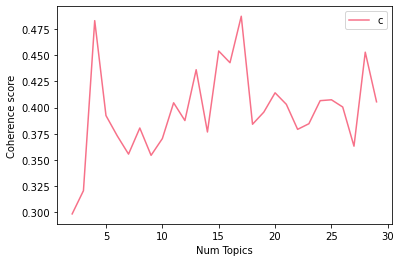

In [84]:
# Show graph
limit=30; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [85]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 2  has Coherence Value of 0.299
Num Topics = 3  has Coherence Value of 0.321
Num Topics = 4  has Coherence Value of 0.483
Num Topics = 5  has Coherence Value of 0.392
Num Topics = 6  has Coherence Value of 0.373
Num Topics = 7  has Coherence Value of 0.356
Num Topics = 8  has Coherence Value of 0.381
Num Topics = 9  has Coherence Value of 0.354
Num Topics = 10  has Coherence Value of 0.37
Num Topics = 11  has Coherence Value of 0.405
Num Topics = 12  has Coherence Value of 0.388
Num Topics = 13  has Coherence Value of 0.436
Num Topics = 14  has Coherence Value of 0.377
Num Topics = 15  has Coherence Value of 0.454
Num Topics = 16  has Coherence Value of 0.443
Num Topics = 17  has Coherence Value of 0.487
Num Topics = 18  has Coherence Value of 0.384
Num Topics = 19  has Coherence Value of 0.396
Num Topics = 20  has Coherence Value of 0.414
Num Topics = 21  has Coherence Value of 0.403
Num Topics = 22  has Coherence Value of 0.379
Num Topics = 23  has Coherence Value of 0.3

In [86]:
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.030*"mug" + 0.019*"price" + 0.018*"r" + 0.016*"design" + 0.016*"day" + 0.015*"coffee" + 0.015*"product" + 0.012*"make" + 0.012*"baby" + 0.011*"gift"'),
 (1,
  '0.033*"product" + 0.030*"watch" + 0.025*"analog" + 0.021*"r" + 0.019*"buy" + 0.019*"delivery" + 0.019*"cash" + 0.018*"replacement" + 0.018*"com" + 0.016*"guarantee"'),
 (2,
  '0.017*"cm" + 0.013*"specification" + 0.012*"pack" + 0.012*"print" + 0.011*"set" + 0.011*"price" + 0.011*"sale" + 0.011*"skin" + 0.010*"feature" + 0.010*"number"'),
 (3,
  '0.029*"product" + 0.024*"com" + 0.023*"flipkart" + 0.023*"buy" + 0.023*"cash" + 0.022*"delivery" + 0.019*"mug" + 0.018*"day" + 0.017*"guarantee" + 0.016*"replacement"'),
 (4,
  '0.023*"cm" + 0.017*"baby" + 0.017*"product" + 0.014*"r" + 0.013*"feature" + 0.013*"price" + 0.012*"girl" + 0.012*"detail" + 0.012*"cotton" + 0.010*"specification"'),
 (5,
  '0.014*"r" + 0.013*"product" + 0.013*"price" + 0.010*"quality" + 0.009*"color" + 0.009*"feature" + 0.009*"l" + 0.009*"replacement" 

# Données Images

In [63]:
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


## Création des labels des photos à partir du nom des images

In [80]:
dataImg=data2[["image","category"]]

In [81]:
dataImg.head()

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


In [82]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dataImg["label"] = le.fit_transform(dataImg["category"])
dataImg.head(5)

<ipython-input-82-928a966fd951>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataImg["label"] = le.fit_transform(dataImg["category"])


,image,category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


In [83]:
dataImg.groupby("label").count()

,image,category
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


## Affichage d'exemples d'images par label

In [84]:
from matplotlib.image import imread

list_labels = ["Baby Care", "Home Furnishing", "Watches", "Home Decor & Festive Needs",
               "Kitchen & Dining","Beauty and Personal Care","Computers"]

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(list_photos)) if dataImg["category"][i]==name]
    return list_image_name

list_Baby_Care=[list_photos[i] for i in range(len(list_photos)) if dataImg["category"][i]=="Baby Care"]
list_Home_Furnishing=[list_photos[i] for i in range(len(list_photos)) if dataImg["category"][i]=="Home Furnishing"]
list_Watches=[list_photos[i] for i in range(len(list_photos)) if dataImg["category"][i]=="Watches"]
list_Home_Decor_Festive_Needs=[list_photos[i] for i in range(len(list_photos)) if dataImg["category"][i]=="Home Decor & Festive Needs"]
list_Kitchen_Dining=[list_photos[i] for i in range(len(list_photos)) if dataImg["category"][i]=="Kitchen & Dining"]
list_Beauty_and_Personal_Care=[list_photos[i] for i in range(len(list_photos)) if dataImg["category"][i]=="Beauty and Personal Care"]
list_Computers=[list_photos[i] for i in range(len(list_photos)) if dataImg["category"][i]=="Computers"]



Baby Care


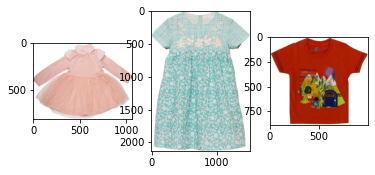

Home Furnishing


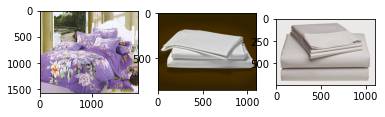

Watches


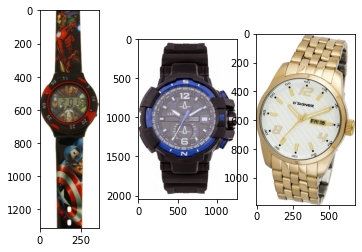

Home Decor & Festive Needs


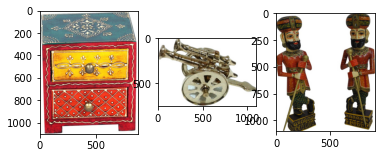

Kitchen & Dining


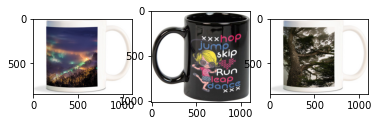

Beauty and Personal Care


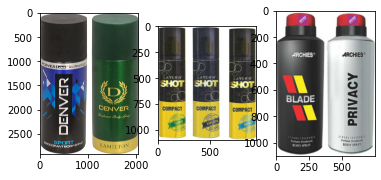

Computers


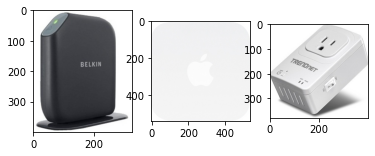

In [85]:
for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = 'C:/Users/Administrator/images/'+list_fct(name)[i+25]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [71]:
path = r"C:/Users/Administrator/images"
list_photos = [dataImg['image'][i] for i in range(dataImg.shape[0])]
print(len(list_photos))

1050


## Détermination et affichage des descripteurs SIFT

In [86]:
import cv2

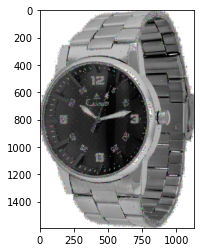

Descripteurs :  (3861, 128)

[[  1.   0.   2. ...   0.   0.   0.]
 [139.  95.   9. ...   0.   1.   0.]
 [167.  12.   0. ...  13.  11.   1.]
 ...
 [109.   4.   0. ...   2.   1.   0.]
 [131.   0.   0. ...   0.   0.   0.]
 [137.   8.   0. ...   2.   0.   0.]]


In [88]:
sift = cv2.SIFT_create()
image1 = cv2.imread("C:/Users/Administrator/images/f355cc1ccb08bd0d283ed979b7ee7515.jpg")
image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image1 = cv2.equalizeHist(image1)
image1=cv2.resize(image1,(400,400))
kp, des = sift.detectAndCompute(image1, None)
img1=cv2.drawKeypoints(image1,kp,image1)
plt.imshow(img1)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


## Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [89]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(1100)

In [90]:
for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    #image = cv2.imread(path+list_photos[image_num],0) # convert in gray  
    image = cv2.imread('C:/Users/Administrator/images/'+dataImg.image.iloc[image_num])
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image=cv2.resize(image,(400,400))
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040


In [91]:
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_by_img2 = np.delete(sift_keypoints_by_img, [343])

sift_keypoints_all    = np.concatenate(sift_keypoints_by_img2, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


Nombre de descripteurs :  (572806, 128)
temps de traitement SIFT descriptor :            76.66 secondes


<ipython-input-91-c75c9f700a69>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


In [ ]:
displayTheFourImagesAndTheirHistograms(dictImages,4)

## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [92]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  757
Création de 757 clusters de descripteurs ...
temps de traitement kmeans :            80.31 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [93]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [94]:
# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img2) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            26.52 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [95]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1049, 757)
Dimensions dataset après réduction PCA :  (1049, 521)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [96]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=150, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = dataImg["category"]
print(df_tsne.shape)


(1049, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images


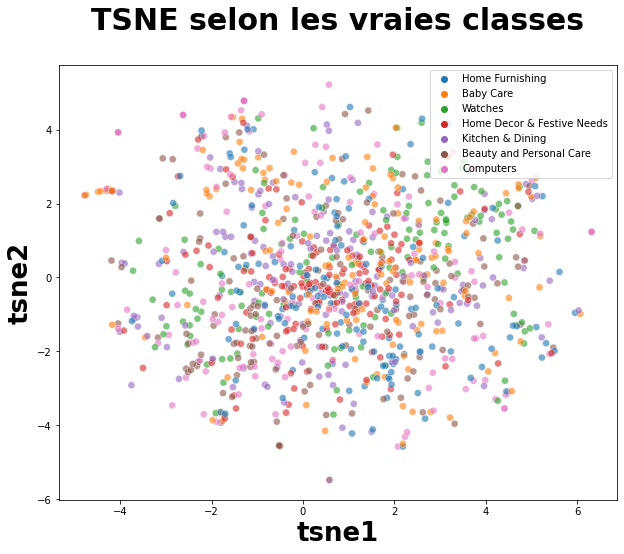

In [97]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [99]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=12)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1049, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters


In [104]:
dataImg2=dataImg.copy()

In [105]:
dataImg2.shape

(1050, 3)

In [110]:
dataImg2.drop(343,0,inplace=True)

<ipython-input-110-46d0f65465c0>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dataImg2.drop(343,0,inplace=True)


In [111]:
dataImg2.shape

(1049, 3)

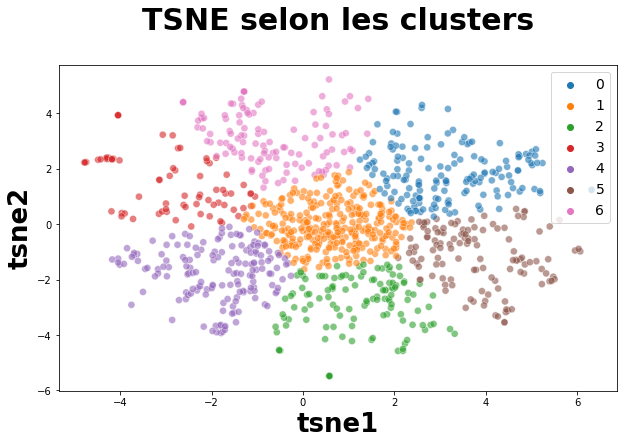

ARI :  0.05145283053958342


In [113]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = dataImg2["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

* Le score ARI de 0.051 est très faible

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation  a été réalisée manuellement au lieu d'utiliser la fonction "argmax"

In [114]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    160
1    300
2    119
3    71 
4    159
5    122
6    118
Name: class, dtype: int64

In [115]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[27 37 17 14 10 17 28]
 [ 7 33 15  8 50 26 11]
 [23 15 16 14 27 24 30]
 [14 86 16 10 16  1  7]
 [ 8 54 39  6  6 22 15]
 [20 47  8 11 21 21 22]
 [61 28  8  8 29 11  5]]


In [116]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [6, 4, 6, 1, 2, 5, 0]  
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6, 4, 6, 1, 2, 5, 0]
[[28 14 10  0 37 17 44]
 [11  8 50  0 33 26 22]
 [30 14 27  0 15 24 39]
 [ 7 10 16  0 86  1 30]
 [15  6  6  0 54 22 47]
 [22 11 21  0 47 21 28]
 [ 5  8 29  0 28 11 69]]

              precision    recall  f1-score   support

           0       0.24      0.19      0.21       150
           1       0.11      0.05      0.07       150
           2       0.17      0.18      0.18       149
           3       0.00      0.00      0.00       150
           4       0.18      0.36      0.24       150
           5       0.17      0.14      0.15       150
           6       0.25      0.46      0.32       150

    accuracy                           0.20      1049
   macro avg       0.16      0.20      0.17      1049
weighted avg       0.16      0.20      0.17      1049



C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

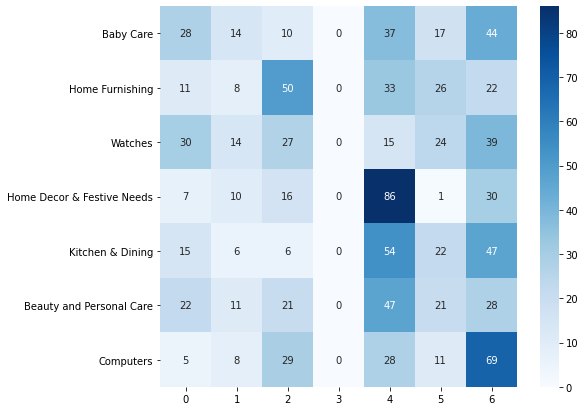

In [117]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")

##  Méthode Transfert Learning avec VGG16

Nous allons dans cette partie utiliser **Keras**, une bibliothèque de **Deep Learning**.

Nous utiliserons une version du réseau de neurones convolutif VGG-Net nommé **VGG16**.

Le modèle **VGG16** atteint une précision de **92,7%** dans le top 5 des tests d'**ImageNet**.<br />
**ImageNet** est un ensemble de données de plus de 15 millions d'images haute résolution étiquetées appartenant à environ **22 000 catégories**. 

**Keras** nous fourni une version pré-entraînée de **VGG16**.

Pour mettre en place notre moteur de classification d'images, nous appliquerons une technique nommée *Transfert Learning*.

Simplement, le *Transfert Learning* consiste à utiliser la connaissance déjà acquise par un modèle entraîné (ici **VGG16**) pour l'adapter à notre problématique.

Actuellement **VGG16** permet de classer une image parmi **1000 catégories** différentes.

Nous souhaitons donc pouvoir utiliser la puissance de **VGG16** mais adaptée à notre problématique. C'est à dire pouvoir classer une image non pas parmi 1000 catégories mais parmi nos 7 catégories.

<u>Voici une vue des différentes couches de VGG16</u> 

![Représentation VGG16](https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png)

**VGG-16** est constitué de plusieurs couches, dont **13** couches de convolution et **3** fully-connected. <br />

Il prend en entrée une image en couleurs de taille 224  × 224 px et la classifie dans une des 1000 classes. <br />
Il renvoie donc un vecteur de taille 1000, qui contient les probabilités d'appartenance à chacune des classes. 

Dans notre approche *Transfert Learning*, nous n'allons pas utiliser la dernière couche **softmax** chargée de classer l'image parmi l'une des 1000 catégories.

Nous récupérerons, pour chaque image, le **vecteur** de dimension (**1**,**1**,**4096**), puis, comme pour la méthode SIFT, ou pour le traitement du texte que nous avons réalisé précedement dans ce projet, nous répéterons les étapes de :
 - Réduction de dimension 
 - Clustering 
 - Et enfin nous calculerons le score ARI entre le groupement des produits selon les catégories et les labels d'un clustering KMeans réalisé sur la projection en 2 dimensions de nos vecteurs.

In [419]:
dataImg

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,image,category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Watches,6
6,f355cc1ccb08bd0d283ed979b7ee7515.jpg,Watches,6
7,dd0e3470a7e6ed76fd69c2da27721041.jpg,Watches,6
8,41384da51732c0b4df3de8f395714fbb.jpg,Watches,6
9,710ed5f2393a4b9e8823aa0029f71f93.jpg,Watches,6


In [202]:
model = VGG16(weights="imagenet",
              include_top=True, # test avec True
              input_shape=(224, 224, 3))

In [203]:
#On indique qu'on ne souhaite ré-entrainer aucune des couches du modèle :
for layer in model.layers:
   layer.trainable = False

On définit le nouveau modèle en définissant son entrée et sa sortie :

<u>En entrée</u>, nous voulons utiliser l'entrée du modèle VGG16<br />
<u>En sortie</u>, nous souhaitons obtenir le vecteur généré par VGG16 juste avant la dernière couche softmax, soit son **avant-dernière couche**.

In [204]:
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [205]:
#Résumé du modèle VGG16
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

<u>Résumé de notre nouveau modèle </u>:<br />
On remarque que la dernière couche n'a pas été importée et que le modèle ne va pas être ré-entrainé, même partiellement.

In [206]:
new_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [207]:
#  Création du dictionnaire dictModel
dictModel={}

In [218]:
# Ajout du path des images
dictModel['path'] = dataImg['image'].apply(lambda row: 'C:/Users/Administrator/images/'+row)

In [219]:
# On importe également sous forme de Series Pandas les catégories associées à chaque image.
dictModel['category'] = dataImg['category']

### Préparation des images

VGG16 attend en entrée une matrice d'images en 4 dimensions composée de la façon suivante</u> :
 - 1ère dimension : Correspond au nombre d'images importées
  - 1050 dans notre cas
 - 2ème et 3ème dimension : correspond à la largeur et hauteur de l'image
  - VGG16 attend en entrée des images de 224 x 224 px.
 - 4ème dimension : Correspond à la profondeur de l'image
  - Vaut 3 si les photos sont en couleurs (notre cas)
  - Vaut 1 si les photos sont en noir et blanc

In [220]:
dictModel = createMatrixOfImages(dictModel)

Dimensions of the image matrix: (1050, 224, 224, 3)


### Extraction des histogrammes

Pour obtenir nos histogrammes avec notre nouveau modèle, il suffit d'utiliser la méthode **predict** en passant en argument la matrice d'images en 4 dimensions.

Le modèle nous retourne une matrice de (ici 1050) vecteurs, où chaque vecteur est de dimension (1, 4096).

In [221]:
dictModel['histograms'] = new_model.predict(dictModel['arrayImg'])

In [222]:
dictModel['histograms'].shape

(1050, 4096)

In [224]:
print("Dimensions dataset avant réduction PCA : ", dictModel['histograms'].shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(dictModel['histograms'])
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 800)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [241]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = dataImg["category"]
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

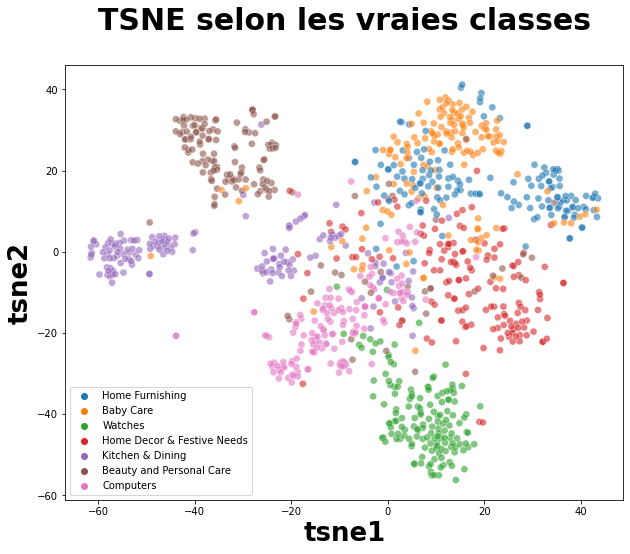

In [242]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

Les produits semblent nettement plus répartis par groupe que lors de l'utilisation de SIFT.<br />
Même si à ce stade il n'est pas possible de savoir à quel point le moteur de classification sera efficace, cette première représentation avec notre model basé sur VGG16 semble plus efficace que la méthode SIFT.

Comme pour le classement à partir de la description texte des images, certaines catégories semblent très bien regroupées comme "**Watches**" ou "**Beauty and Personal Care**".D'autres sont plus diffuses comme "**Home Furnising**".

On peut émettre l'hypothèse que les groupes correctement taggués ont des caractéristiques visuelles très spécifiques alors que les autres ont des caractéristiques plus générales et susceptibles d'être présentes dans plusieurs catégories.

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [243]:

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.48

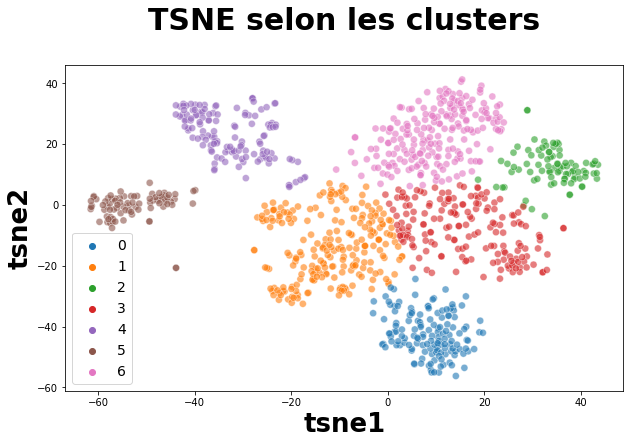

ARI :  0.47667956738821043


In [244]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = dataImg["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation  a été réalisée manuellement au lieu d'utiliser la fonction "argmax"

In [245]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    141
1    227
2    87 
3    171
4    131
5    82 
6    211
Name: class, dtype: int64

In [246]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  1   8  10  16   3   1 111]
 [  1  13   2  10 116   1   7]
 [  0 122   0  22   1   2   3]
 [  3  18   5 112   1   0  11]
 [  0   1  70   3   0   0  76]
 [  0  52   0   7  10  78   3]
 [136  13   0   1   0   0   0]]


In [247]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [6, 4, 1, 3, 2, 5, 0]  
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6, 4, 1, 3, 2, 5, 0]
[[111  10   3  16   8   1   1]
 [  7   2 116  10  13   1   1]
 [  3   0   1  22 122   2   0]
 [ 11   5   1 112  18   0   3]
 [ 76  70   0   3   1   0   0]
 [  3   0  10   7  52  78   0]
 [  0   0   0   1  13   0 136]]

              precision    recall  f1-score   support

           0       0.53      0.74      0.61       150
           1       0.02      0.01      0.02       150
           2       0.01      0.01      0.01       150
           3       0.65      0.75      0.70       150
           4       0.00      0.01      0.01       150
           5       0.95      0.52      0.67       150
           6       0.96      0.91      0.93       150

    accuracy                           0.42      1050
   macro avg       0.45      0.42      0.42      1050
weighted avg       0.45      0.42      0.42      1050



<AxesSubplot:>

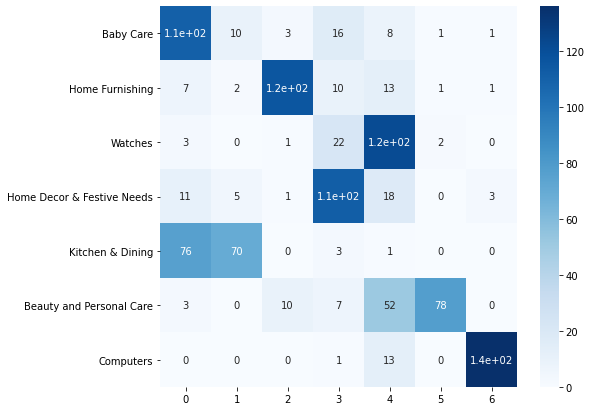

In [248]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Fusion des features Textes et Images

Nous avons testé notre moteur de classification à partir des **textes de description** des produits puis de leurs **images**, nous allons tenter d'améliorer l'efficacité de notre moteur de classification en fusionnant les vecteurs de caractéristiques obtenus avec **TF-IDF** pour l'analyse textuelle, puis les vecteurs issus de notre modèle basé sur **VGG16** pour l'analyse des images.

Nous obtiendrons ainsi, pour chaque produit, un unique vecteur de caractéristiques provenant à la fois des features textes et images.

Les étapes de réalisation seront exactement les mêmes que vu précedement.

**On a crée un nouveau dictionnaire dans lequel j'importe**:
 - Les vecteurs de caractéristiques textuelles
 - Les vecteurs de caractéristiques des images <br />
   obtenus à partir du modèle basé sur VGG16
 - La liste des catégories associées à chaque produit.

In [399]:
# Création du dictionnaire dictTxt
dictTxtImages = {}

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [400]:
dictTxtImages['category'] = dictTxt['category']

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [401]:
dictTxtImages['tfidf'] = dictTxt['tfidf']

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [402]:
dictTxtImages['histograms'] = dictModel['histograms']

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [403]:
# Fusion des vecteurs de caractéristiques de textes et d'images
dictTxtImages = combineTwoMatricesInOne(dictTxtImages)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dimensions of two matrices:
   Matrix n°1 -- Name: tfidf -- Shape: (1050, 3508)
   Matrix n°2 -- Name: histograms -- Shape: (1050, 4096)
Final matrix -- Name: vectors -- Shape: (1050, 7604)


In [404]:
#On effectue la réduction des vecteurs en 2 dimensions :
dictTxtImages = reductionTwoDimensionPCAandTSNE(dictTxtImages)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Treatment of the column histograms
Dimension of the original data set: (1050, 4096)
Start of PCA processing:
Variance preserved: 99.0%
Data set size after PCA processing: (1050, 800)
End of PCA processing.
Start T-SNE processing:


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
C:\Users\Admini

Size of the dataset after T-SNE processing: (1050, 2)
End of T-SNE processing.


In [405]:
print("Dimensions dataset avant réduction PCA : ", dictTxtImages['histograms'].shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(dictTxtImages['histograms'])
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)


C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dimensions dataset après réduction PCA :  (1050, 800)


In [407]:
# Clustering PCA / T-SNE
dictModel = reductionTwoDimensionPCAandTSNE(dictModel)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Treatment of the column histograms
Dimension of the original data set: (1050, 4096)
Start of PCA processing:
Variance preserved: 99.0%
Data set size after PCA processing: (1050, 800)
End of PCA processing.
Start T-SNE processing:


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
C:\Users\Admini

Size of the dataset after T-SNE processing: (1050, 2)
End of T-SNE processing.


C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


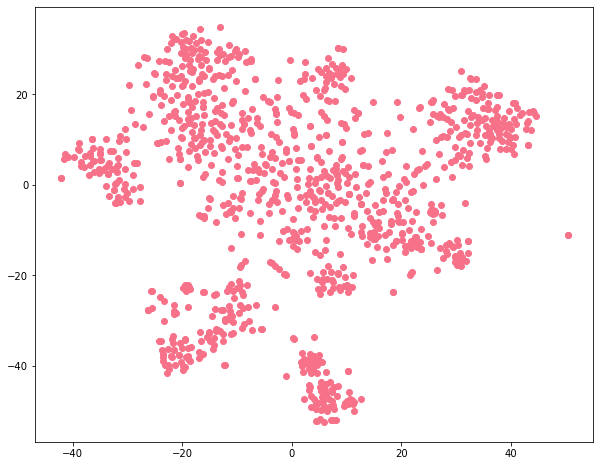

In [408]:
plt.figure(figsize=(10,8))
plt.scatter(dictModel['tsne'][:,0], dictModel['tsne'][:,1])

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


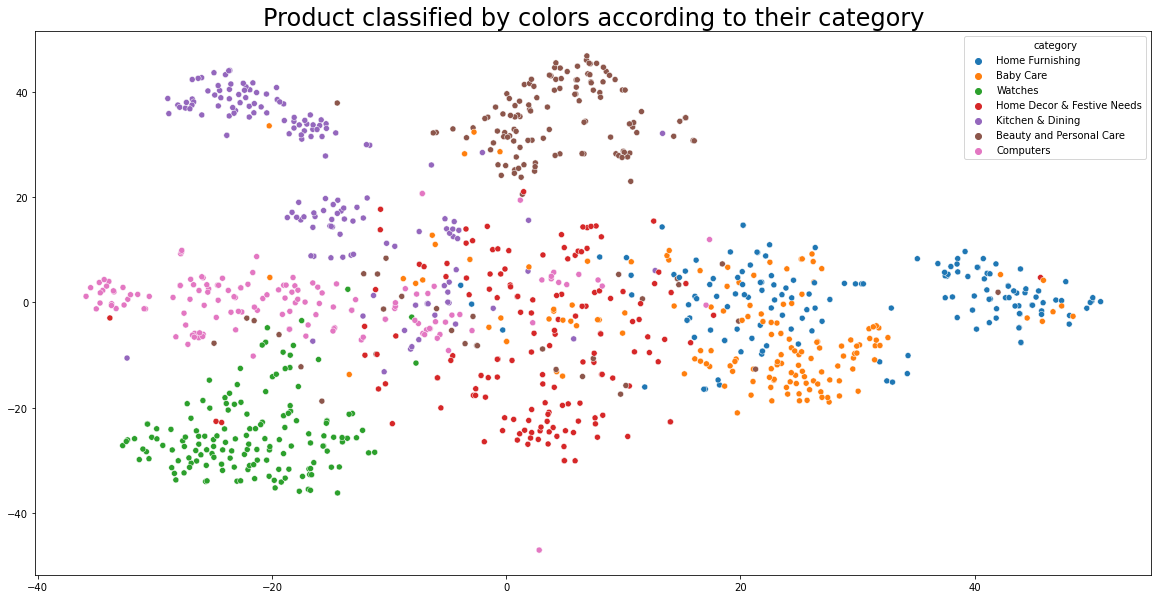

In [413]:
# Affichage de la classification des produits selon leurs catégories
displayTSNESortedByColor(dictTxtImages,hue='category')

Comme pour le classement à partir de la description texte des images, certaines catégories semblent très bien regroupées comme "**Watches**" ou "**Beauty and Personal Care**". D'autres sont plus diffuses comme "**Computers**".

In [414]:
# K-Means sur matrice T-SNE
dictTxtImages = createKMeansLabelsFromTSNE(dictTxtImages)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


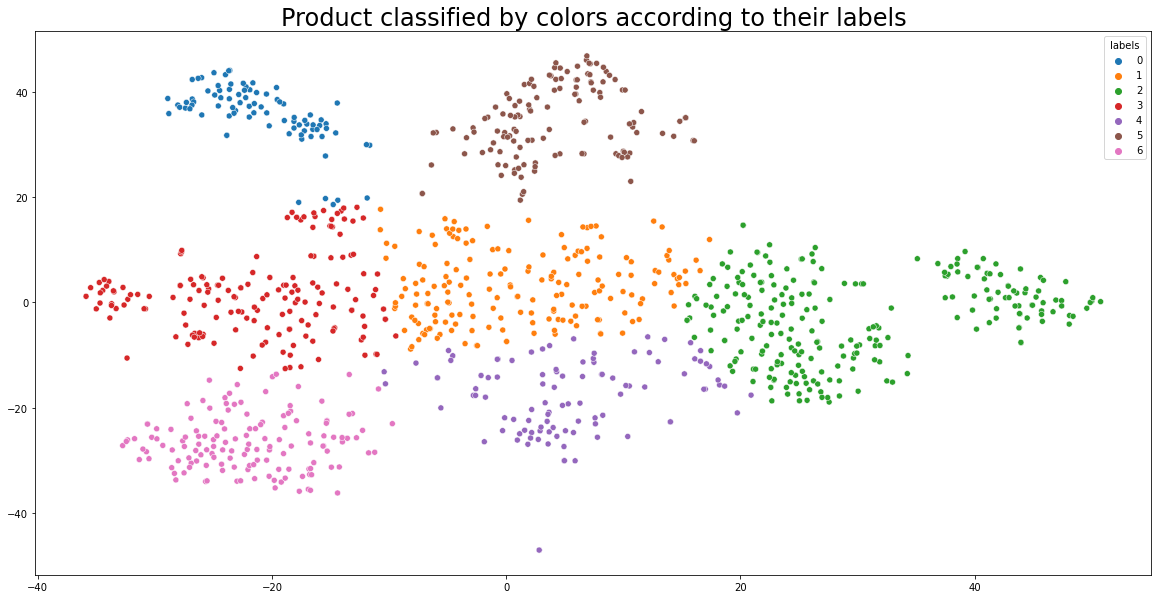

In [415]:
#Affichons maintenant les produits selon leurs clusters K-Means : 
displayTSNESortedByColor(dictTxtImages,hue='labels')

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


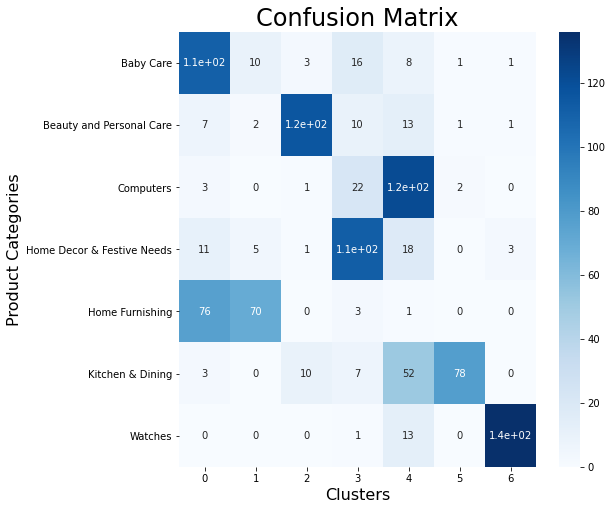

In [416]:
#Utilisons la **matrice de confusion** pour visualiser les erreurs de classement.
showConfusionMatrix(dictTxtImages)

In [417]:
# Calcul du Score ARI
viewARIScore(dictTxtImages)

ARI score between clustering according
to categories and KMeans labels: 0.4859652405759912


C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


# Conclusion

Nous avons successivement tenté de classer nos produits à partir de leurs données descriptives **textuelles** ainsi qu'à partir de leurs **images**.<br />
Nous avons ensuite tenté de classer les produits en **fusionnant** les données textes et images.

Les tests ont été réalisés à partir d'un petit échantillon de **1050** produits.

A ce stade la classification à partir des données textes (description) donne les résultats les plus satisfaisants. L'analyse d'images n'apporte pas de précision supplémentaire.

Cependant, la précision du moteur de classification basée sur l'analyse des images peut être grandement améliorée si nous décidons, par exemple, de ré-entrainer un modèle basé sur **VGG16** à partir d'une base d'images correspondant à nos catégories de produits.

Globalement, les résultats sont très **encourageants** et nous permettent de donner un avis **positif** sur la faisabilité du moteur de classification.